<a href="https://colab.research.google.com/github/jang-jin/ML-Class/blob/master/1_sell_time_predict_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# import function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"R^2 : {r2_score(y_test, y_pred)}")
    print(f"RMSE : {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred)}")

def predict_test_dl(model, X_test, N):
    result = np.empty((X_test.shape[0], 0))
    test = X_test.copy()

    for _ in tqdm(range(120//N)):
        y_pred = model.predict(test)
        test = np.concatenate((test[:, N:, :], y_pred.reshape(X_test.shape[0], N, 1)), axis=1)
        result = np.concatenate((result, y_pred.reshape(X_test.shape[0], N)), axis=1)
    return result

In [3]:
# data load
PATH = '/content/drive/MyDrive/Colab Notebooks/DACON_ai_bit_trader_contest'

train_x_df = pd.read_csv(PATH+"/data/train_x_df.csv")
train_y_df = pd.read_csv(PATH+"/data/train_y_df.csv")

train_x = train_x_df.values.reshape((-1,1380,12))
train_y = train_y_df.values.reshape((-1,120,12))

train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [4]:
sample_x = train_x[:,:,3:]
sample_y = train_y[:,:,3:]

X_train, X_test, y_train, y_test = train_test_split(sample_x, sample_y, random_state=13)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5745, 1380, 9) (5745, 120, 9)
(1916, 1380, 9) (1916, 120, 9)


# 1. t+1 예측하기

### 1) 특성 1380 * 9 개

In [11]:
X_train_ml = X_train.reshape((X_train.shape[0],-1))
X_test_ml = X_test.reshape((X_test.shape[0],-1))
y_train_ml = y_train[:,0,0]
y_test_ml = y_test[:,0,0]
print(X_train_ml.shape, y_train_ml.shape)
print(X_test_ml.shape, y_test_ml.shape)

(5745, 12420) (5745,)
(1916, 12420) (1916,)


##### 1-1. RF

In [ ]:
start = time.time()

rf = RandomForestRegressor().fit(X_train_ml, X_train_ml)

end = int(time.time() - start)
print(f"time : {end//3600}시간 {end%3600//60}분 {end%60}초")

time : 1.0시간 49.0분 29.317044258117676초


In [ ]:
print_score(rf, X_test_ml, y_test_ml)

R^2 : 0.788008780179985
RMSE : 0.0008242755495042898
MAPE : 0.03652796410318511


In [ ]:
(rf.feature_importances_>sorted(rf.feature_importances_, reverse=True)[10]).nonzero()

(array([ 2821,  9403, 11713, 12206, 12340, 12349, 12351, 12412, 12413,
        12414]),)

In [ ]:
(rf.feature_importances_>sorted(rf.feature_importances_, reverse=True)[10]).nonzero()[0]%9

array([4, 7, 4, 2, 1, 1, 3, 1, 2, 3])

In [ ]:
(rf.feature_importances_>sorted(rf.feature_importances_, reverse=True)[10]).nonzero()[0]//9

array([ 313, 1044, 1301, 1356, 1371, 1372, 1372, 1379, 1379, 1379])

##### 1-2. Lasso

In [ ]:
for a in tqdm([100, 10, 1, 0.1, 0.01]):
    lasso = Lasso(alpha=a).fit(X_train_ml, y_train_ml)
    score = lasso.score(X_test_ml, y_test_ml)
    print(f"alpha : {a}, score : {score}")

 20%|██        | 1/5 [00:06<00:27,  6.92s/it]

alpha : 100, score : -0.12912313831538502


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046695635144941225, tolerance: 1.6354556423532514e-06
  positive)
 40%|████      | 2/5 [01:14<01:15, 25.18s/it]

alpha : 10, score : -2.8984853455565194


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004942724072110977, tolerance: 1.6354556423532514e-06
  positive)
 60%|██████    | 3/5 [02:16<01:12, 36.14s/it]

alpha : 1, score : -15.205523009034579


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0050069044010546, tolerance: 1.6354556423532514e-06
  positive)
 80%|████████  | 4/5 [03:24<00:45, 45.65s/it]

alpha : 0.1, score : -28.078313383694436


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004651277262327424, tolerance: 1.6354556423532514e-06
  positive)
100%|██████████| 5/5 [04:34<00:00, 54.99s/it]

alpha : 0.01, score : -65.03469067880016


In [ ]:
for a in tqdm([1000,10000]):
    lasso = Lasso(alpha=a).fit(X_train_ml, y_train_ml)
    score = lasso.score(X_test_ml, y_test_ml)
    print(f"alpha : {a}, score : {score}")

 50%|█████     | 1/2 [00:01<00:01,  1.04s/it]

alpha : 1000, score : 0.0006951997070026028


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

alpha : 10000, score : -0.0009823679744760394


In [ ]:
lasso.coef_.nonzero()

(array([], dtype=int64),)

##### 1-3. 번외) 종가 예측

In [62]:
X_train_ml = X_train.reshape((X_train.shape[0],-1))
X_test_ml = X_test.reshape((X_test.shape[0],-1))
y_train_ml = y_train[:,0,3]
y_test_ml = y_test[:,0,3]
print(X_train_ml.shape, y_train_ml.shape)
print(X_test_ml.shape, y_test_ml.shape)

(5745, 12420) (5745,)
(1916, 12420) (1916,)


In [ ]:
start = time.time()

rf = RandomForestRegressor().fit(X_train_ml, X_train_ml)

end = int(time.time() - start)
print(f"time : {end//3600}시간 {end%3600//60}분 {end%60}초")

In [ ]:
print_score(rf, X_test_ml, y_test_ml)

###2) t-10 시가

In [5]:
X_train_ml = X_train[:,-10:,0]
X_test_ml = X_test[:,-10:,0]
y_train_ml = y_train[:,0,0]
y_test_ml = y_test[:,0,0]
print(X_train_ml.shape, y_train_ml.shape)
print(X_test_ml.shape, y_test_ml.shape)

(5745, 10) (5745,)
(1916, 10) (1916,)


##### 2-1. RF

In [56]:
start = time.time()

rf = RandomForestRegressor().fit(X_train_ml, y_train_ml)

end = int(time.time() - start)
print(f"time : {end//3600}시간 {end%3600//60}분 {end%60}초")

time : 0시간 0분 18초


In [57]:
print_score(rf, X_test_ml, y_test_ml)

R^2 : -0.1187278827325613
RMSE : 0.0018935453543256246
MAPE : 0.10166611710526202


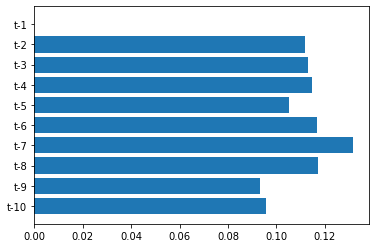

In [58]:
plt.barh(range(X_train_ml.shape[1]), rf.feature_importances_, align='center')
plt.yticks(range(X_train_ml.shape[1]), [f't-{i}' for i in range(X_train_ml.shape[1], 0, -1)])
plt.show()

In [59]:
result = np.empty((X_test_ml.shape[0], 0))
test = X_test_ml.copy()

for _ in tqdm(range(y_test.shape[1])):
    y_pred = rf.predict(test).reshape(-1, 1)
    test = np.concatenate((test[:, 1:], y_pred), axis=1)
    result = np.concatenate((result, y_pred), axis=1)
print()
print(result.shape)

100%|██████████| 120/120 [00:09<00:00, 12.41it/s]


(1916, 120)


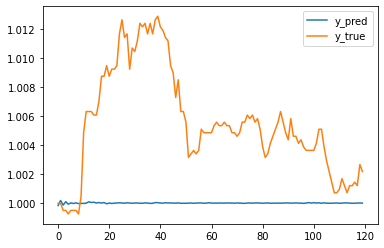

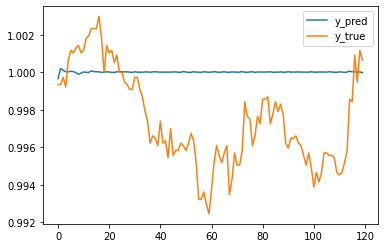

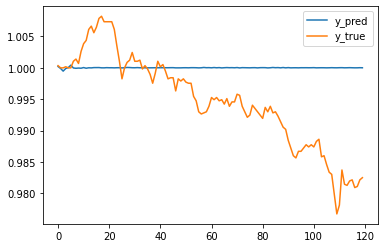

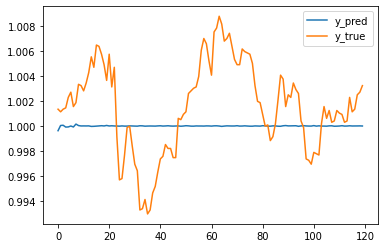

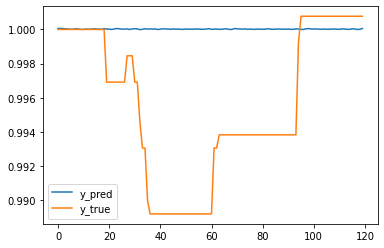

In [61]:
for i in range(5):
    plt.plot(result[i], label="y_pred")
    plt.plot(y_test[i,:,0], label="y_true")
    plt.legend()
    plt.show()

 - 1분씩 예측하는 것은 오차가 많을 수 있겠다.

##### 2-2. SVR

In [6]:
for c in tqdm([1000, 100, 10, 1, 0.1, 0.01, 0.001]):
    svr = SVR(C=c)
    score = cross_val_score(svr, X_train_ml, y_train_ml, cv=5).mean()
    print(f"C : {c}, score : {score}")

100%|██████████| 7/7 [00:00<00:00, 57.49it/s]

C : 1000, score : -0.48818920055361675
C : 100, score : -0.48818920055361675
C : 10, score : -0.48818920055361675
C : 1, score : -0.48818920055361675
C : 0.1, score : -0.48818920055361675
C : 0.01, score : -0.48818920055361675
C : 0.001, score : -0.48818920055361675


##### 2-3. Ridge

In [7]:
for a in tqdm([0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    ridge = Ridge(alpha=a)
    score = cross_val_score(ridge, X_train_ml, y_train_ml, cv=5).mean()
    print(f"alpha : {a}, score : {score}")

100%|██████████| 7/7 [00:00<00:00, 40.70it/s]

alpha : 0.001, score : 0.020125856086933736
alpha : 0.01, score : 0.02314547870240453
alpha : 0.1, score : 0.025367206609550032
alpha : 1, score : 0.017083894048854
alpha : 10, score : 0.0017315168919443292
alpha : 100, score : -0.0013078089508898661
alpha : 1000, score : -0.001638845575246206


In [8]:
lr = LinearRegression().fit(X_train_ml, y_train_ml)
print_score(lr, X_test_ml, y_test_ml)

R^2 : -0.031884181508988085
RMSE : 0.0018185655429146077
MAPE : 0.09731289273296832


##### 2-4. LSTM

In [9]:
X_train_dl = X_train[:,-10:,0].reshape((X_train.shape[0],10,1))
X_test_dl = X_test[:,-10:,0].reshape((X_test.shape[0],10,1))
y_train_dl = y_train[:,0,0]
y_test_dl = y_test[:,0,0]
print(X_train_dl.shape, y_train_dl.shape)
print(X_test_dl.shape, y_test_dl.shape)

(5745, 10, 1) (5745,)
(1916, 10, 1) (1916,)


In [10]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')
model.summary()

model.fit(X_train_dl, y_train_dl,
          epochs=10,
          batch_size=128,
          validation_data=(X_test_dl, y_test_dl))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
45/45 [==============================] - 3s 26ms/step - loss: 0.6689 - val_loss: 0.0018
Epoch 2/10
45/45 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 2.8247e-05
Epoch 3/10
45/45 [==============================] - 0s 8ms/step - loss: 3.7398e-05 - val_loss: 7.3332e-06
Epoch 4/10
45/45 [==============================] - 0s 8ms/step - loss: 5.5230e-06 - val_loss: 6.4925e-06
Epoch 5/10
45/45 [==============================] - 0s 9ms/step - loss: 6.3475e-06 - val_loss: 6.5008e-

In [11]:
print_score(model, X_test_dl, y_test_dl)

R^2 : -1.0253178728749726
RMSE : 0.0025477691714907015
MAPE : 0.16005905114494764


In [12]:
result = np.empty((X_test_dl.shape[0], 0))
test = X_test_dl.copy()

for _ in tqdm(range(y_test.shape[1])):
    y_pred = model.predict(test)
    test = np.concatenate((test[:, 1:, :], y_pred.reshape(-1, 1, 1)), axis=1)
    result = np.concatenate((result, y_pred.reshape(-1, 1)), axis=1)
print()
print(result.shape)

100%|██████████| 120/120 [00:15<00:00,  7.65it/s]


(1916, 120)


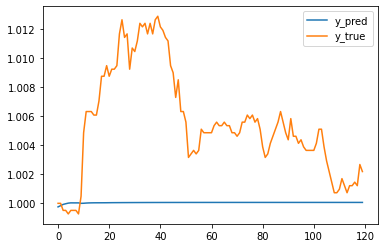

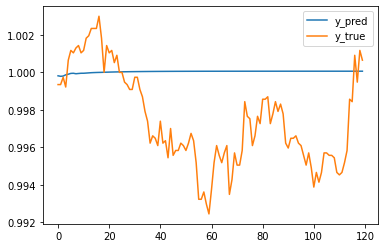

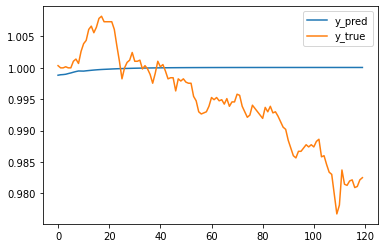

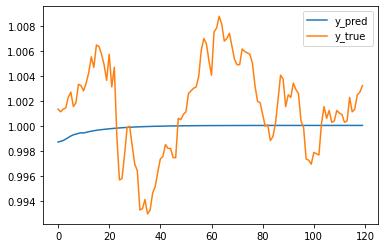

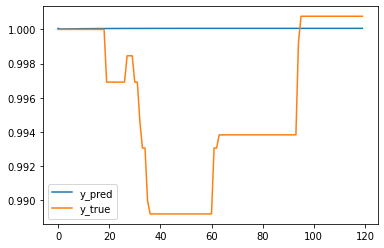

In [13]:
for i in range(5):
    plt.plot(result[i], label="y_pred")
    plt.plot(y_test[i,:,0], label="y_true")
    plt.legend()
    plt.show()

### 3) t-120 시가

In [21]:
X_train_ml = X_train[:,-120:,0].reshape((X_train.shape[0],-1))
X_test_ml = X_test[:,-120:,0].reshape((X_test.shape[0],-1))
y_train_ml = y_train[:,0,0]
y_test_ml = y_test[:,0,0]
X_train_dl = X_train[:,-120:,0].reshape((X_train.shape[0],-1,1))
X_test_dl = X_test[:,-120:,0].reshape((X_test.shape[0],-1,1))
y_train_dl = y_train[:,0,0]
y_test_dl = y_test[:,0,0]
print(X_train_ml.shape, y_train_ml.shape)
print(X_test_ml.shape, y_test_ml.shape)
print(X_train_dl.shape, y_train_dl.shape)
print(X_test_dl.shape, y_test_dl.shape)

(5745, 120) (5745,)
(1916, 120) (1916,)
(5745, 120, 1) (5745,)
(1916, 120, 1) (1916,)


In [20]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])))
lstm.add(Dense(1, activation='linear'))

lstm.compile(loss='mse', optimizer='adam')
lstm.summary()

lstm.fit(X_train_dl, y_train_dl,
         epochs=5,
         batch_size=32,
         validation_data=(X_test_dl, y_test_dl))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
180/180 [==============================] - 11s 50ms/step - loss: 0.0667 - val_loss: 1.5104e-04
Epoch 2/5
180/180 [==============================] - 9s 48ms/step - loss: 1.6498e-04 - val_loss: 1.4751e-04
Epoch 3/5
180/180 [==============================] - 9s 48ms/step - loss: 1.5484e-04 - val_loss: 1.4744e-04
Epoch 4/5
180/180 [==============================] - 9s 49ms/step - loss: 1.8257e-04 - val_loss: 1.5132e-04
Epoch 5/5
180/180 [==============================] - 9s 49ms/step - loss: 1.6583e-04 

In [16]:
print_score(lstm, X_test_dl, y_test_dl)

R^2 : -0.9601199845462476
RMSE : 0.0025064255494982334
MAPE : 0.15702333615155475


In [17]:
result = predict_test_dl(lstm, X_test_dl, 1)

100%|██████████| 120/120 [01:12<00:00,  1.65it/s]


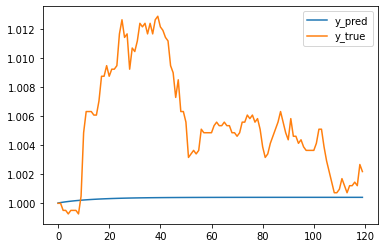

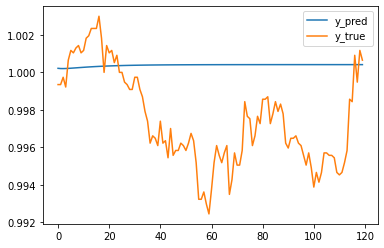

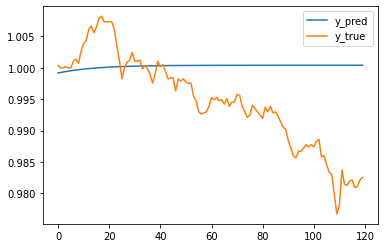

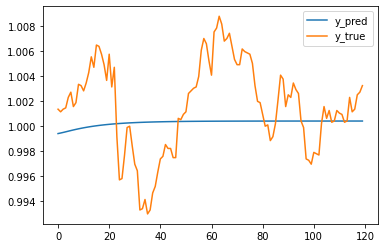

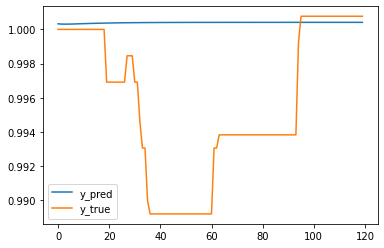

In [18]:
for i in range(5):
    plt.plot(result[i], label="y_pred")
    plt.plot(y_test[i,:,0], label="y_true")
    plt.legend()
    plt.show()

### 4) t-1380 시가

In [5]:
X_train_ml = X_train[:,:,0]
X_test_ml = X_test[:,:,0]
y_train_ml = y_train[:,0,0]
y_test_ml = y_test[:,0,0]
print(X_train_ml.shape, y_train_ml.shape)
print(X_test_ml.shape, y_test_ml.shape)

(5745, 1380) (5745,)
(1916, 1380) (1916,)


In [6]:
start = time.time()

rf = RandomForestRegressor().fit(X_train_ml, y_train_ml)

end = int(time.time() - start)
print(f"time : {end//3600}시간 {end%3600//60}분 {end%60}초")

time : 0시간 46분 54초


In [7]:
print_score(rf, X_test_ml, y_test_ml)

R^2 : -0.03686291503654493
RMSE : 0.0018229474582178854
MAPE : 0.09759278801604333


In [8]:
(rf.feature_importances_>sorted(rf.feature_importances_, reverse=True)[10]).nonzero()

(array([1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378]),)

# 2. t+120 예측하기

In [22]:
X_train_dl = X_train[:,-120:,0].reshape((X_train.shape[0],-1,1))
X_test_dl = X_test[:,-120:,0].reshape((X_test.shape[0],-1,1))
y_train_dl = y_train[:,:,0]
y_test_dl = y_test[:,:,0]
print(X_train_dl.shape, y_train_dl.shape)
print(X_test_dl.shape, y_test_dl.shape)

(5745, 120, 1) (5745, 120)
(1916, 120, 1) (1916, 120)


In [23]:
lstm = Sequential()
lstm.add(LSTM(128, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])))
lstm.add(Dense(120, activation='linear'))

lstm.compile(loss='mse', optimizer='adam')
lstm.summary()

lstm.fit(X_train_dl, y_train_dl,
         epochs=5,
         batch_size=32,
         validation_data=(X_test_dl, y_test_dl))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 120)               15480     
Total params: 82,040
Trainable params: 82,040
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
180/180 [==============================] - 22s 113ms/step - loss: 0.1992 - val_loss: 1.4549e-04
Epoch 2/5
180/180 [==============================] - 20s 110ms/step - loss: 1.4847e-04 - val_loss: 1.5176e-04
Epoch 3/5
180/180 [==============================] - 20s 110ms/step - loss: 1.7920e-04 - val_loss: 1.5543e-04
Epoch 4/5
180/180 [==============================] - 20s 110ms/step - loss: 1.6802e-04 - val_loss: 1.4881e-04
Epoch 5/5
180/180 [==============================] - 20s 110ms/step - loss: 

In [25]:
print_score(lstm, X_test_dl, y_test_dl)

R^2 : -0.0836125374881037
RMSE : 0.012408818417926614
MAPE : 0.7344637455728142


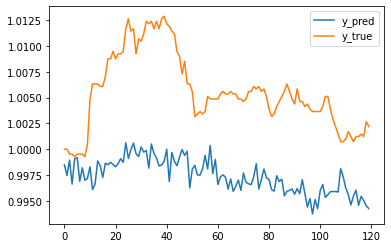

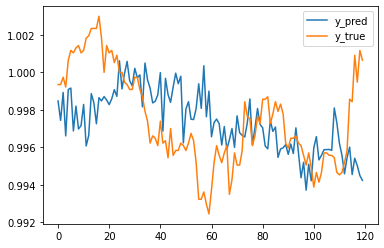

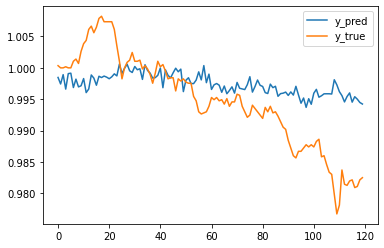

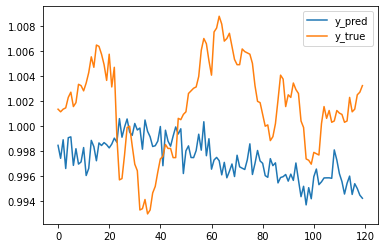

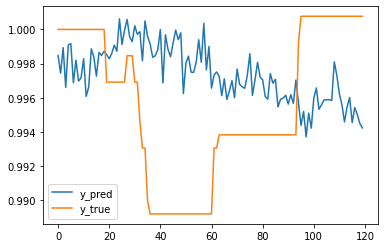

In [26]:
result = lstm.predict(X_test_dl)

for i in range(5):
    plt.plot(result[i], label="y_pred")
    plt.plot(y_test[i,:,0], label="y_true")
    plt.legend()
    plt.show()

# 3. t+N으로 예측하기

(5745, 120, 1) (5745, 20)
(1916, 120, 1) (1916, 20)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2580      
Total params: 69,140
Trainable params: 69,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
180/180 [==============================] - 22s 111ms/step - loss: 0.1620 - val_loss: 3.2543e-05
Epoch 2/5
180/180 [==============================] - 20s 110ms/step - loss: 4.0078e-05 - val_loss: 3.2311e-05
Epoch 3/5
180/180 [==============================] - 20s 110ms/step - loss: 3.2912e-05 - val_loss: 3.2235e-05
Epoch 4/5
180/180 [==============================] - 20s 110ms/step - loss: 3.2678e-05 - val_loss: 3.2888e-05
Epoch 5/5
180/180 [=====

  0%|          | 0/6 [00:00<?, ?it/s]

R^2 : -0.03992751838591905
RMSE : 0.005723093007472009
MAPE : 0.31924501588230125


100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


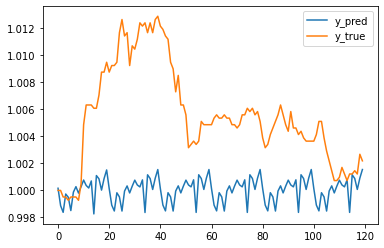

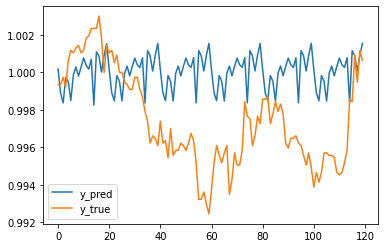

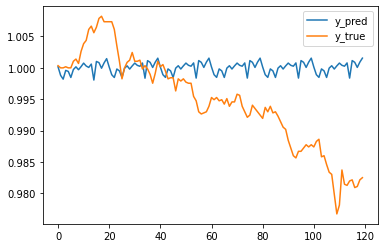

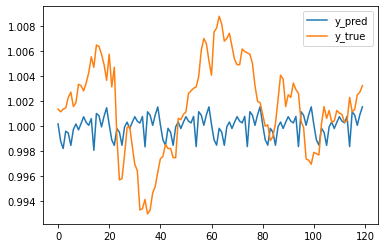

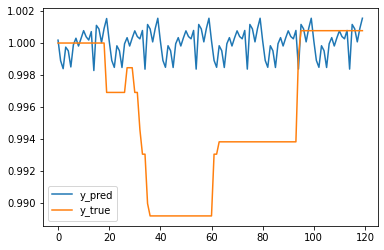

In [27]:
N = 20

X_train_dl = X_train[:,-120:,0].reshape((X_train.shape[0],-1,1))
X_test_dl = X_test[:,-120:,0].reshape((X_test.shape[0],-1,1))
y_train_dl = y_train[:,:N,0]
y_test_dl = y_test[:,:N,0]
print(X_train_dl.shape, y_train_dl.shape)
print(X_test_dl.shape, y_test_dl.shape)

lstm = Sequential()
lstm.add(LSTM(128, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])))
lstm.add(Dense(N, activation='linear'))

lstm.compile(loss='mse', optimizer='adam')
lstm.summary()

lstm.fit(X_train_dl, y_train_dl,
         epochs=5,
         batch_size=32,
         validation_data=(X_test_dl, y_test_dl))

print_score(lstm, X_test_dl, y_test_dl)

result = predict_test_dl(lstm, X_test_dl, N)

for i in range(5):
    plt.plot(result[i], label="y_pred")
    plt.plot(y_test[i,:,0], label="y_true")
    plt.legend()
    plt.show()